In [77]:
import os
import glob
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from skimage import io
from skimage import color
from skimage import filters
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import LinearSVC
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [78]:
from pathlib import Path
TRAIN_DIR = Path("C:/Users/sagar/OneDrive/Desktop/dataset.dm/train")
TEST_DIR = Path("C:/Users/sagar/OneDrive/Desktop/dataset.dm/test")
print("Train contents:")
for p in TRAIN_DIR.iterdir():
    print(p.name)
print("Test contents:")
for p in TEST_DIR.iterdir():
    print(p.name)



Train contents:
airplanes
cars
ships
Test contents:
airplanes
cars
ships


In [79]:
CLASS_NAMES = []
for p in TRAIN_DIR.iterdir():
    if p.is_dir():
        CLASS_NAMES.append(p.name)
CLASS_NAMES.sort()
print("Classes (from train):", CLASS_NAMES)


Classes (from train): ['airplanes', 'cars', 'ships']


In [80]:
CLASS_NAMES = []
for p in TEST_DIR.iterdir():
    if p.is_dir():
        CLASS_NAMES.append(p.name)
CLASS_NAMES.sort()
print("Classes (from test):", CLASS_NAMES)


Classes (from test): ['airplanes', 'cars', 'ships']


In [81]:
from skimage import color, filters
from skimage.transform import resize
import numpy as np
def extract_edge_histogram(img, bins=36, min_side=64):
    if img is None or not hasattr(img, "ndim"):
        return np.zeros(bins, dtype=np.float32)
    try:
        if img.ndim == 3:
            img = img[..., :3]
            gray = color.rgb2gray(img)
        else:
            gray = img.astype(np.float32)
    except Exception:
        return np.zeros(bins, dtype=np.float32)
    try:
        gray = resize(gray, (min_side, min_side), anti_aliasing=True)
    except Exception:
        return np.zeros(bins, dtype=np.float32)
    gx = filters.sobel_h(gray)
    gy = filters.sobel_v(gray)
    mag = np.hypot(gx, gy)
    ang = np.arctan2(gy, gx)
    hist = np.histogram(ang, bins=bins, range=(-np.pi, np.pi), weights=mag)[0]
    s = hist.sum()
    if s > 0:
        hist = hist / s
    return hist.astype(np.float32)


In [82]:
X = []
y = []
exts = ["*.jpg", "*.jpeg", "*.png", "*.bmp", "*.tif", "*.tiff", "*.webp", "*.jfif"]
for label in range(len(CLASS_NAMES)):
    cls = CLASS_NAMES[label]
    cls_dir = TRAIN_DIR / cls
    files = []
    for e in exts:
        files.extend(list(cls_dir.glob(e)))
    print(cls, len(files), "images found")
    for p in files:
        img = io.imread(p)
        feat = extract_edge_histogram(img, bins=36)
        X.append(feat)
        y.append(label)
X = np.array(X)
y = np.array(y)
print("Feature array shape:", X.shape)


airplanes 1000 images found
cars 1000 images found
ships 1000 images found
Feature array shape: (3000, 36)


In [83]:
def split_train_test(X, y, test_ratio=0.2):
    X_train = []
    y_train = []
    X_test = []
    y_test = []
    classes = np.unique(y)
    for c in classes:
        idx = np.where(y == c)[0]
        np.random.shuffle(idx)
        n = len(idx)
        n_test = int(n * test_ratio)
        n_train = n - n_test
        train_idx = idx[:n_train]
        test_idx = idx[n_train:]
        for i in train_idx:
            X_train.append(X[i])
            y_train.append(c)
        for i in test_idx:
            X_test.append(X[i])
            y_test.append(c)
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    return X_train, X_test, y_train, y_test



In [84]:
X_train, X_test, y_train, y_test = split_train_test(X, y, test_ratio=0.2)
print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)


Train shape: (2400, 36) (2400,)
Test shape: (600, 36) (600,)


In [85]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=True, with_std=True)
X_train_std = scaler.fit_transform(X_train)
X_test_std  = scaler.transform(X_test)
print(X_train_std)
print(X_test_std)

[[ 1.5450562   0.7895875   0.39342856 ... -0.38043433 -0.9114836
  -0.17476764]
 [ 0.28222236 -0.15316431 -0.49221304 ...  0.34071833  0.68914586
   0.82463294]
 [-1.3060167  -0.759893    1.5627501  ...  0.83789665  1.9776801
  -0.46937415]
 ...
 [-1.0890728  -0.89999837 -0.8631304  ... -0.45026886  0.03006567
  -1.070194  ]
 [ 0.31945416 -0.6678895  -0.09641837 ... -0.3827349  -0.69876677
   0.57029164]
 [-0.48008803 -0.235465   -0.56514156 ...  0.3026649   0.56292504
   0.40202418]]
[[ 1.1728189   1.1850435  -0.05886754 ... -0.9399865  -0.2113539
   0.8555773 ]
 [ 1.5380259   0.42399377 -0.8175329  ... -0.52977496 -0.6782101
   0.6280029 ]
 [-0.902893   -0.02453162 -1.0477922  ... -0.60387844 -0.5548216
  -0.13400574]
 ...
 [-0.8500018  -0.13640027 -0.43215808 ...  0.31799272 -0.04752506
  -0.4470146 ]
 [ 0.3607692  -1.7459526  -1.4078454  ... -1.2291077  -1.5182619
   0.6513949 ]
 [-0.91145355 -0.10847766 -0.17827168 ...  0.05977321 -0.6604916
  -0.85847956]]


In [86]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
models = {
    "NaiveBayes": GaussianNB(),
    "NeuralNet":  MLPClassifier(hidden_layer_sizes=(10,10,10),
                                max_iter=500, random_state=RANDOM_STATE),
    "AdaBoost":   AdaBoostClassifier(random_state=RANDOM_STATE)
}
print("\n=== 5-fold CV on TRAIN (accuracy) ===")
cv_scores = {}
for name, clf in models.items():
    scores = cross_val_score(clf, X_train_std, y_train, cv=skf, scoring="accuracy", n_jobs=-1)
    cv_scores[name] = scores
    print(f"{name:10s}: mean={scores.mean():.4f}  std={scores.std():.4f}")



=== 5-fold CV on TRAIN (accuracy) ===
NaiveBayes: mean=0.6142  std=0.0279
NeuralNet : mean=0.6458  std=0.0305
AdaBoost  : mean=0.6029  std=0.0198


C:\Users\sagar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


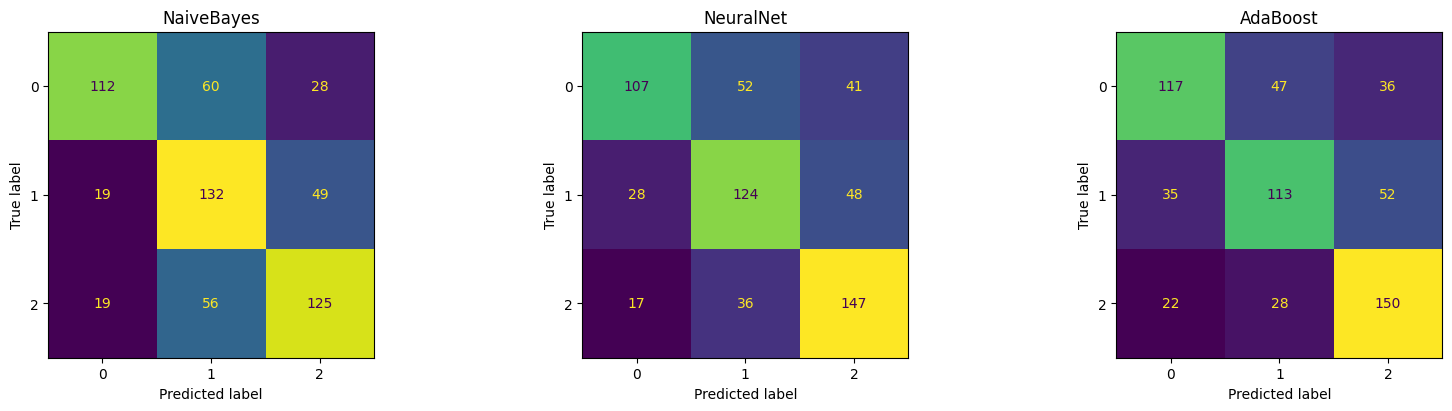

In [87]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4), constrained_layout=True)
test_metrics = {}
unique_labels = np.unique(y_test)
for ax, (name, clf) in zip(axes, models.items()):
    if name == "NaiveBayes":
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
    else:
        clf.fit(X_train_std, y_train)
        y_pred = clf.predict(X_test_std)
    acc = accuracy_score(y_test, y_pred)
    f1m = f1_score(y_test, y_pred, average="macro")
    test_metrics[name] = {"accuracy": acc, "f1_macro": f1m}
    cm = confusion_matrix(y_test, y_pred, labels=unique_labels)
    disp = ConfusionMatrixDisplay(cm, display_labels=unique_labels)
    disp.plot(ax=ax, colorbar=False)
    ax.set_title(name)
plt.show()


In [88]:
print("\n=== TEST SET PERFORMANCE ===")
print(f"{'Model':15s} | {'Accuracy':>10s} | {'F1 (Macro)':>10s}")
print("-" * 40)
for name, m in test_metrics.items():
    print(f"{name:15s} | {m['accuracy']:.4f}     | {m['f1_macro']:.4f}")



=== TEST SET PERFORMANCE ===
Model           |   Accuracy | F1 (Macro)
----------------------------------------
NaiveBayes      | 0.6150     | 0.6171
NeuralNet       | 0.6300     | 0.6281
AdaBoost        | 0.6333     | 0.6310


In [ ]:
Q1 By visually comparing (e.g., looking at the color on the diagonal values, etc.) the three confusion
matrices (on the test set), which do you think is the best method? Why?
AdaBoost is the best model visually because it has the highest number of correct predictions along the diagonal and fewer misclassifications than Naive Bayes and the Neural Network. Its matrix shows the most concentrated diagonal values, indicating stronger class separation.
Q2)Based on the mean validation accuracies (from the 5-fold cross-validation) for the three methods.
Which is the best method?
The Neural Network (MLP) has the highest mean validation accuracy (0.6458), making it the best model according to cross-validation performance..
Q3)Compute the accuracies for the three methods on the test set. Which is the best method? (0.25
point)
The AdaBoost classifier has the highest test accuracy (0.6333). So it is the best method.
Q4)• Compute the F-measure for the three methods on the test set. Which is the best method? (0.25
point)
Since AdaBoost also yields the highest macro-F1 (0.6310), it performs best when balancing precision and recall across all classes, which is important in multi-class classification

In [89]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import KFold
selected_classes = ["airplanes", "cars"]
selected_ids = [CLASS_NAMES.index(c) for c in selected_classes]
def subset_by_classes(X, y, keep_ids):
    mask = np.isin(y, keep_ids)
    Xs, ys = X[mask], y[mask]
    mapping = {cid: i for i, cid in enumerate(sorted(keep_ids))}
    ys = np.array([mapping[v] for v in ys], dtype=int)
    return Xs, ys
X_train2, y_train2 = subset_by_classes(X_train_std, y_train, selected_ids)
X_test2,  y_test2  = subset_by_classes(X_test_std,  y_test,  selected_ids)


In [90]:
C_grid = [0.1, 1, 10, 100]
kf_standard   = KFold(n_splits=5, shuffle=True, random_state=42)
kf_stratified = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [91]:
train_err_std, val_err_std   = [], []
train_err_strat, val_err_strat = [], []
for C in C_grid:
    model = LinearSVC(C=C, dual="auto", random_state=42, max_iter=5000)
    tr_scores, va_scores = [], []
    for tr_idx, va_idx in kf_standard.split(X_train2):
        Xtr, Xva = X_train2[tr_idx], X_train2[va_idx]
        ytr, yva = y_train2[tr_idx], y_train2[va_idx]
        model.fit(Xtr, ytr)
        tr_scores.append(model.score(Xtr, ytr))
        va_scores.append(model.score(Xva, yva))
    train_err_std.append(1 - np.mean(tr_scores))
    val_err_std.append(1 - np.mean(va_scores))
    tr_scores, va_scores = [], []
    for tr_idx, va_idx in kf_stratified.split(X_train2, y_train2):
        Xtr, Xva = X_train2[tr_idx], X_train2[va_idx]
        ytr, yva = y_train2[tr_idx], y_train2[va_idx]
        model.fit(Xtr, ytr)
        tr_scores.append(model.score(Xtr, ytr))
        va_scores.append(model.score(Xva, yva))
    train_err_strat.append(1 - np.mean(tr_scores))
    val_err_strat.append(1 - np.mean(va_scores))


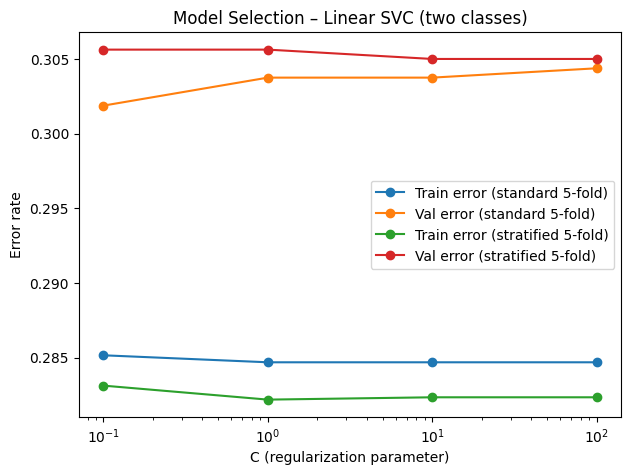

In [92]:
plt.figure(figsize=(7,5))
plt.plot(C_grid, train_err_std,   marker='o', label='Train error (standard 5-fold)')
plt.plot(C_grid, val_err_std,     marker='o', label='Val error (standard 5-fold)')
plt.plot(C_grid, train_err_strat, marker='o', label='Train error (stratified 5-fold)')
plt.plot(C_grid, val_err_strat,   marker='o', label='Val error (stratified 5-fold)')
plt.xscale('log')
plt.xlabel('C (regularization parameter)')
plt.ylabel('Error rate')
plt.title('Model Selection – Linear SVC (two classes)')
plt.legend()
plt.show()


In [95]:
best_C = C_grid[np.argmin(val_err_strat)]
print(f"Best C (from stratified 5-fold): {best_C}")
final_svm = LinearSVC(C=best_C, dual="auto", random_state=42, max_iter=5000)
final_svm.fit(X_train2, y_train2)
test_acc = final_svm.score(X_test2, y_test2)
test_err = 1 - test_acc
print(f"Two-class TEST accuracy (best C={best_C}): {test_acc:.4f}")
print(f"Two-class TEST error (best C={best_C}):    {test_err:.4f}")



Best C (from stratified 5-fold): 10
Two-class TEST accuracy (best C=10): 0.6900
Two-class TEST error (best C=10):    0.3100


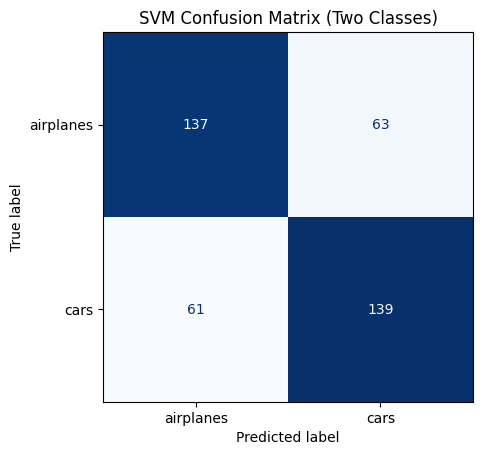

SVM test accuracy: 0.6900
SVM macro-F1:      0.6900


In [96]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score
import matplotlib.pyplot as plt
y_pred_svm = final_svm.predict(X_test2)
svm_acc = accuracy_score(y_test2, y_pred_svm)
svm_f1  = f1_score(y_test2, y_pred_svm, average="macro")
test_metrics["SVM"] = {"accuracy": svm_acc, "f1_macro": svm_f1}
cm_svm = confusion_matrix(y_test2, y_pred_svm, labels=[0,1])
disp = ConfusionMatrixDisplay(cm_svm, display_labels=selected_classes)
disp.plot(cmap="Blues", colorbar=False)
plt.title("SVM Confusion Matrix (Two Classes)")
plt.show()
print(f"SVM test accuracy: {svm_acc:.4f}")
print(f"SVM macro-F1:      {svm_f1:.4f}")


Q) Which 𝐶 has/have the lowest mean error for each curve? Comment about (1) the model complexity for SVM in relation to 𝐶, and (2) when/whether there is overfitting/underfitting.
From the plot, the lowest mean validation error (stratified 5-fold) occurs at C = 1 (very close to C = 10). The training and validation curves are almost flat, which shows that model performance does not change much as C increases.
1)Small C (e.g., 0.1) - increased regularization - less complicated model - a bit larger error.
2)Bigger C (e.g., 10, 100) - less aggressive regularization - more complicated model - however, there is no significant performance enhancement.
3)With the curve being nearly linear, further raising C does not have a significant effect on complexity or accuracy and so, the dataset is already approaching the linearly separable state.
Overfitting/Underfitting:
Training error is never too high, it is underfitting slightly, but not seriously.
No acute jump of train and validation errors - no overfitting at C value.
The model is also stable in terms of C values and C = 1 is a decent balance (minimum validation error, not over-complex).
Q)what is the error for the test dataset (i.e., the standardized edge histogram
dataset obtained from the test set)
So the test error = 1 − 0.69 = 0.31